<a href="https://colab.research.google.com/github/malinphy/q_17/blob/main/pca_svm_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install scann -q

In [3]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from numpy.random import seed
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scann
plt.style.use('ggplot')
# import openai
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler

In [4]:
def apk(actual, predicted, k=10):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0
    hits = []
    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)
        hits.append(num_hits)
    # if not actual:
    #     return 0.0
    # print(((hits)))
    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

def intersect(actual, predicted,k):
    return np.intersect1d(actual[:k], predicted[:k])

def hit_rate(actual, predicted,k):
    total = 0
    for i in range(len(actual)):
        intersection = intersect(actual[i], predicted[i],k)
        total = total + len(intersection)

    return total

In [5]:
vector_dir = 'drive/MyDrive/BBC_content_vectors.npy'
title_dir = 'drive/MyDrive/transfer/title_vectors_gpt.npy'
embedding_vectors = np.load(vector_dir)
title_gpt_vectors = np.squeeze(np.load(title_dir))
print((embedding_vectors).shape)
print(title_gpt_vectors.shape)

(15468, 1536)
(15468, 1536)


In [6]:
pca_ = PCA(n_components=256, random_state = 42, svd_solver = 'arpack')
embedding_vectors_pca = pca_.fit_transform(embedding_vectors)
title_vectors_pca = pca_.transform(title_gpt_vectors)

svd_ = TruncatedSVD(n_iter= 20, n_components = 256 ).fit(embedding_vectors)
embedding_vectors_svd = svd_.fit_transform(embedding_vectors)
title_vectors_svd = svd_.transform(title_gpt_vectors)

In [7]:
searcher_raw = scann.scann_ops_pybind.builder(embedding_vectors, 50, "dot_product").tree(
    num_leaves=1500, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca = scann.scann_ops_pybind.builder(embedding_vectors_pca, 50, "dot_product").tree(
    num_leaves=1500, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_svd = scann.scann_ops_pybind.builder(embedding_vectors_svd, 50, "dot_product").tree(
    num_leaves=1500, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()            

In [8]:
raw_idx = []
reduced_idx_pca = []
reduced_idx_svd = []
for i in range(100):
    raw_idx.append(searcher_raw.search(title_gpt_vectors[i])[0])
    reduced_idx_pca.append(searcher_pca.search(title_vectors_pca[i])[0])
    reduced_idx_svd.append(searcher_svd.search(title_vectors_svd[i])[0])

raw_idx = np.array(raw_idx,dtype = 'int32')  
raw_idx_pca = np.array(reduced_idx_pca,dtype = 'int32')  

In [9]:
k = [1,3,4,10,15,20,30]
ap_pca = []
for i in k:
    ap_pca.append( mapk(raw_idx, reduced_idx_pca,k=i))

ap_svd = []
for i in k:
    ap_svd.append( mapk(raw_idx, reduced_idx_svd,k=i))


hit_pca = []
for i in k:
    hit_pca.append( hit_rate(raw_idx, reduced_idx_svd,k=i)) 

hit_svd = []
for i in k:
    hit_svd.append( hit_rate(raw_idx, reduced_idx_svd,k=i))         

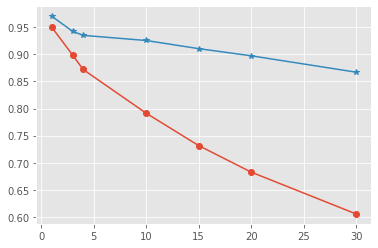

In [10]:
plt.plot(k,ap_pca, 'o-')
plt.plot(k,ap_svd, '-*')

(0.0, 500.0)

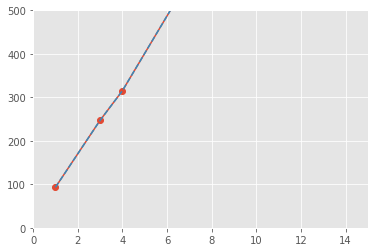

In [13]:
plt.plot(k,hit_pca, 'o-')
plt.plot(k,hit_svd, '--')
plt.xlim([0,15])
plt.ylim([0,500])